<a href="https://colab.research.google.com/github/qubvel-org/segmentation_models.pytorch/blob/main/notebooks/SuperGlue_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SuperGlue Image Keypoints Matching

This notebook introduces [SuperGlue](https://huggingface.co/docs/transformers/main/en/model_doc/superglue), a neural network model designed to improve the matching of keypoints between pairs of images. Keypoints are distinctive points in an image, such as corners or blobs, that algorithms use to identify similarities between different images. Traditional methods often struggle with accurately matching these keypoints, especially when images have variations in viewpoint, lighting, or occlusions.

SuperGlue addresses these challenges by considering not just the individual keypoints, but also the context of their surrounding areas and their relationships to other keypoints. It uses a type of neural network called a graph neural network (GNN) to process and enhance the information from keypoints in two images simultaneously. This approach allows SuperGlue to effectively determine which keypoints in one image correspond to those in another, even under difficult conditions.

By learning patterns from data, SuperGlue can predict the best matches between keypoints and identify points that don't have a match, making it more robust than traditional methods. This capability is particularly useful in applications like 3D reconstruction, where understanding the spatial relationship between different images is crucial.

![](https://psarlin.com/superglue/assets/animations/teaser_animation_v2-all_compressed.gif)

- Paper https://arxiv.org/abs/1911.11763

First, let's make sure we have latest `transformers` installed.

In [13]:
!pip install -U -q git+https://github.com/sbucaille/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.6 MB/s eta 0:00:00


In this notebook, you'll explore how to use the SuperGlue model to match keypoints between two images. Here's what the notebook covers:

- Load pair of images
- Load pretrained SuperGlue model from [Hugging Face Hub](https://huggingface.co/magic-leap-community)
- Run Keypoints Detection & Matching
- Visualized mathced keypoints on images side-by-side


In [2]:
import torch
import requests

from PIL import Image
from transformers import AutoImageProcessor, SuperGlueForKeypointMatching

#### Load images

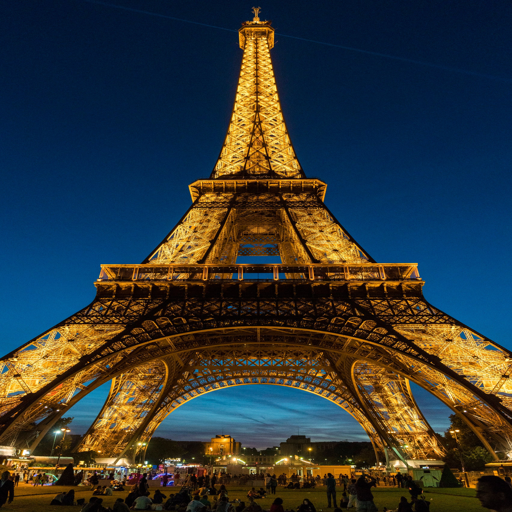

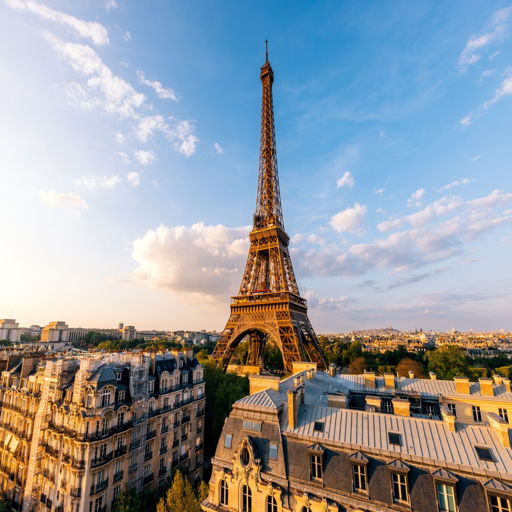

In [3]:
url_image1 = "https://i.etsystatic.com/8026687/r/il/e16641/1436085510/il_fullxfull.1436085510_8o7t.jpg"
url_image2 = "https://hips.hearstapps.com/hmg-prod/images/paris-skyline-with-eiffel-tower-on-a-sunny-day-wide-royalty-free-image-1722542465.jpg"

image1 = Image.open(requests.get(url_image1, stream=True).raw)
image2 = Image.open(requests.get(url_image2, stream=True).raw)

display(image1.resize([512, 512]))
display(image2.resize([512, 512]))

#### Load pretraiend model and image processor from Hugging Face Hub

The image processor handles all necessary preprocessing steps, such as resizing and normalizing the images, before feeding them into the network. This means you don't need to worry about these details.

In [ ]:
processor = AutoImageProcessor.from_pretrained("magic-leap-community/superglue_outdoor")
model = SuperGlueForKeypointMatching.from_pretrained("magic-leap-community/superglue_outdoor")

#### Run keypoints detection & matching

The Transformers implementation of the SuperGlue model is built on top of [SuperPoint](https://huggingface.co/docs/transformers/main/en/model_doc/superpoint). This means you don't need to handle keypoint detection separately, as both steps are seamlessly handled by the SuperGlue model under the hood.

In [35]:
# pre process input pairs of images
images = [[image1, image2], ]
inputs = processor(images, return_tensors="pt")

# run forward
with torch.no_grad():
    outputs = model(**inputs)

# post-process: map keypoints to the original (non-resized) image and filter by matching confidence
image_sizes = [[(image.height, image.width) for image in pair_of_images] for pair_of_images in images]
results = processor.post_process_keypoint_matching(outputs, image_sizes, threshold=0.2)

for i, result in enumerate(results):
    print(f"For the image pair #{i} `image1` match `image2` at keypoints:")
    for keypoint0, keypoint1, matching_score in zip(
            result["keypoints0"], result["keypoints1"], result["matching_scores"]
    ):
        xy1 = tuple(keypoint0.numpy())
        xy2 = tuple(keypoint1.numpy())
        print(
            f"  - xy1 {str(xy1):12s} <-> xy2 {str(xy1):12s} confidence = {matching_score:.2f}"
        )

For the image pair #0 `image1` match `image2` at keypoints:
  - xy1 (848, 42)    <-> xy2 (848, 42)    confidence = 0.43
  - xy1 (816, 107)   <-> xy2 (816, 107)   confidence = 0.43
  - xy1 (859, 107)   <-> xy2 (859, 107)   confidence = 0.41
  - xy1 (888, 107)   <-> xy2 (888, 107)   confidence = 0.53
  - xy1 (792, 150)   <-> xy2 (792, 150)   confidence = 0.23
  - xy1 (910, 150)   <-> xy2 (910, 150)   confidence = 0.48
  - xy1 (886, 182)   <-> xy2 (886, 182)   confidence = 0.39
  - xy1 (816, 193)   <-> xy2 (816, 193)   confidence = 0.42
  - xy1 (894, 257)   <-> xy2 (894, 257)   confidence = 0.46
  - xy1 (787, 456)   <-> xy2 (787, 456)   confidence = 0.26
  - xy1 (920, 461)   <-> xy2 (920, 461)   confidence = 0.23
  - xy1 (960, 703)   <-> xy2 (960, 703)   confidence = 0.21
  - xy1 (745, 730)   <-> xy2 (745, 730)   confidence = 0.33
  - xy1 (830, 730)   <-> xy2 (830, 730)   confidence = 0.41
  - xy1 (822, 789)   <-> xy2 (822, 789)   confidence = 0.33
  - xy1 (891, 789)   <-> xy2 (891, 789) 

## Visualize results

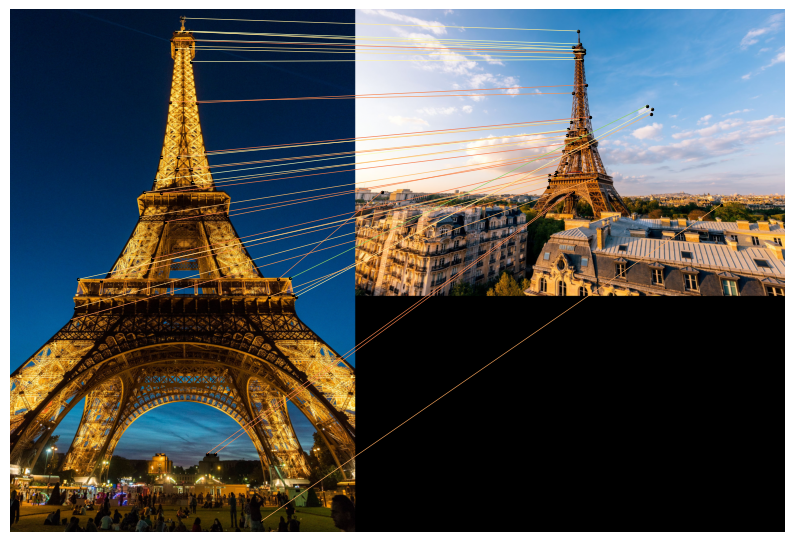

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Create side by side image
merged_image = np.zeros((max(image1.height, image2.height), image1.width + image2.width, 3))
merged_image[: image1.height, : image1.width] = np.array(image1) / 255.0
merged_image[: image2.height, image1.width :] = np.array(image2) / 255.0

plt.figure(figsize=(10, 10))
plt.imshow(merged_image)
plt.axis("off")

# Retrieve the keypoints and matches
output = results[0]
keypoints0 = output["keypoints0"]
keypoints1 = output["keypoints1"]
matching_scores = output["matching_scores"]
keypoints0_x, keypoints0_y = keypoints0[:, 0].numpy(), keypoints0[:, 1].numpy()
keypoints1_x, keypoints1_y = keypoints1[:, 0].numpy(), keypoints1[:, 1].numpy()

# Plot the matches
for keypoint0_x, keypoint0_y, keypoint1_x, keypoint1_y, matching_score in zip(
        keypoints0_x, keypoints0_y, keypoints1_x, keypoints1_y, matching_scores
):
    plt.plot(
        [keypoint0_x, keypoint1_x + image1.width],
        [keypoint0_y, keypoint1_y],
        color=plt.get_cmap("RdYlGn")(matching_score.item()),
        alpha=0.9,
        linewidth=0.5,
    )
    plt.scatter(keypoint0_x, keypoint0_y, c="black", s=2)
    plt.scatter(keypoint1_x + image1.width, keypoint1_y, c="black", s=2)

plt.show()